# Accuracy versus energy
Goals=Compare energy consumed versus learning advancement.

No information on training accuracy, only evaluations.

ToDo:
- compute total energy timeserie
- plot in parallel with accuracy
- compute energy between each eval

In [13]:
import pandas as pd
# import modin.pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
save_dir = f"{processed_log_dir}/dlrm/"
log_dir = f"{logs}/resultats_11-23/"
path = f"{log_dir}/dlrm/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"

# energy = dd.read_csv(
#     energy_file, 
#     dtype={'cpu': 'object', 'socket': 'object', 'domain': 'object'}).drop(columns=["Unnamed: 0"])
# energy.to_parquet(save_dir+'energy.parquet', engine='pyarrow')
energy = dd.read_parquet(save_dir+'energy.parquet', engine='pyarrow')
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])
jobs = jobs[~jobs["job"].isin([126279,126280,126281,126282,126283])]

In [2]:
job = 126295
plot_df = jobs[(jobs["job"]==job)]

In [3]:
file = plot_df.file.values[0]
file.split("/")[-2:]

['126295', '231106171937795433022_raw_1.log']

In [4]:
import sys
sys.path.append("../../logging/mlperf_logging/")
from compliance_checker.mlp_parser import parse_file


log_file = path + "/".join(file.split("/")[-2:])
print(log_file)

loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

/Users/mathildepro/Documents/code_projects/logs/Apollo/resultats_11-23//dlrm/126295/231106171937795433022_raw_1.log


In [5]:
mllog = mllog.drop(['metadata.file', 'metadata.lineno', 'metadata.tensor', 'metadata.status'], axis=1)

In [6]:
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
table = mllog[mllog["value"].notna()].dropna(axis=1,how='all')
cols = [x for x in table.columns] # if (x != "full_string") and (x != "metadata")]
table[cols].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,value,metadata.epoch_num,timestamp,key
0,dlrm,nan,1699287875069.000000,submission_benchmark
1,HPE,nan,1699287875075.000000,submission_org
2,closed,nan,1699287875076.000000,submission_division
3,onprem,nan,1699287875076.000000,submission_status
4,1xSUBMISSION_PLATFORM_PLACEHOLDER,nan,1699287875076.000000,submission_platform
5,89137319,nan,1699287875076.000000,eval_samples
6,55296,nan,1699287875076.000000,global_batch_size
7,24.000000,nan,1699287875076.000000,opt_base_learning_rate
8,24.000000,nan,1699287875076.000000,sgd_opt_base_learning_rate
9,2.000000,nan,1699287875076.000000,sgd_opt_learning_rate_decay_poly_power


Text(0, 0.5, 'Accuracy')

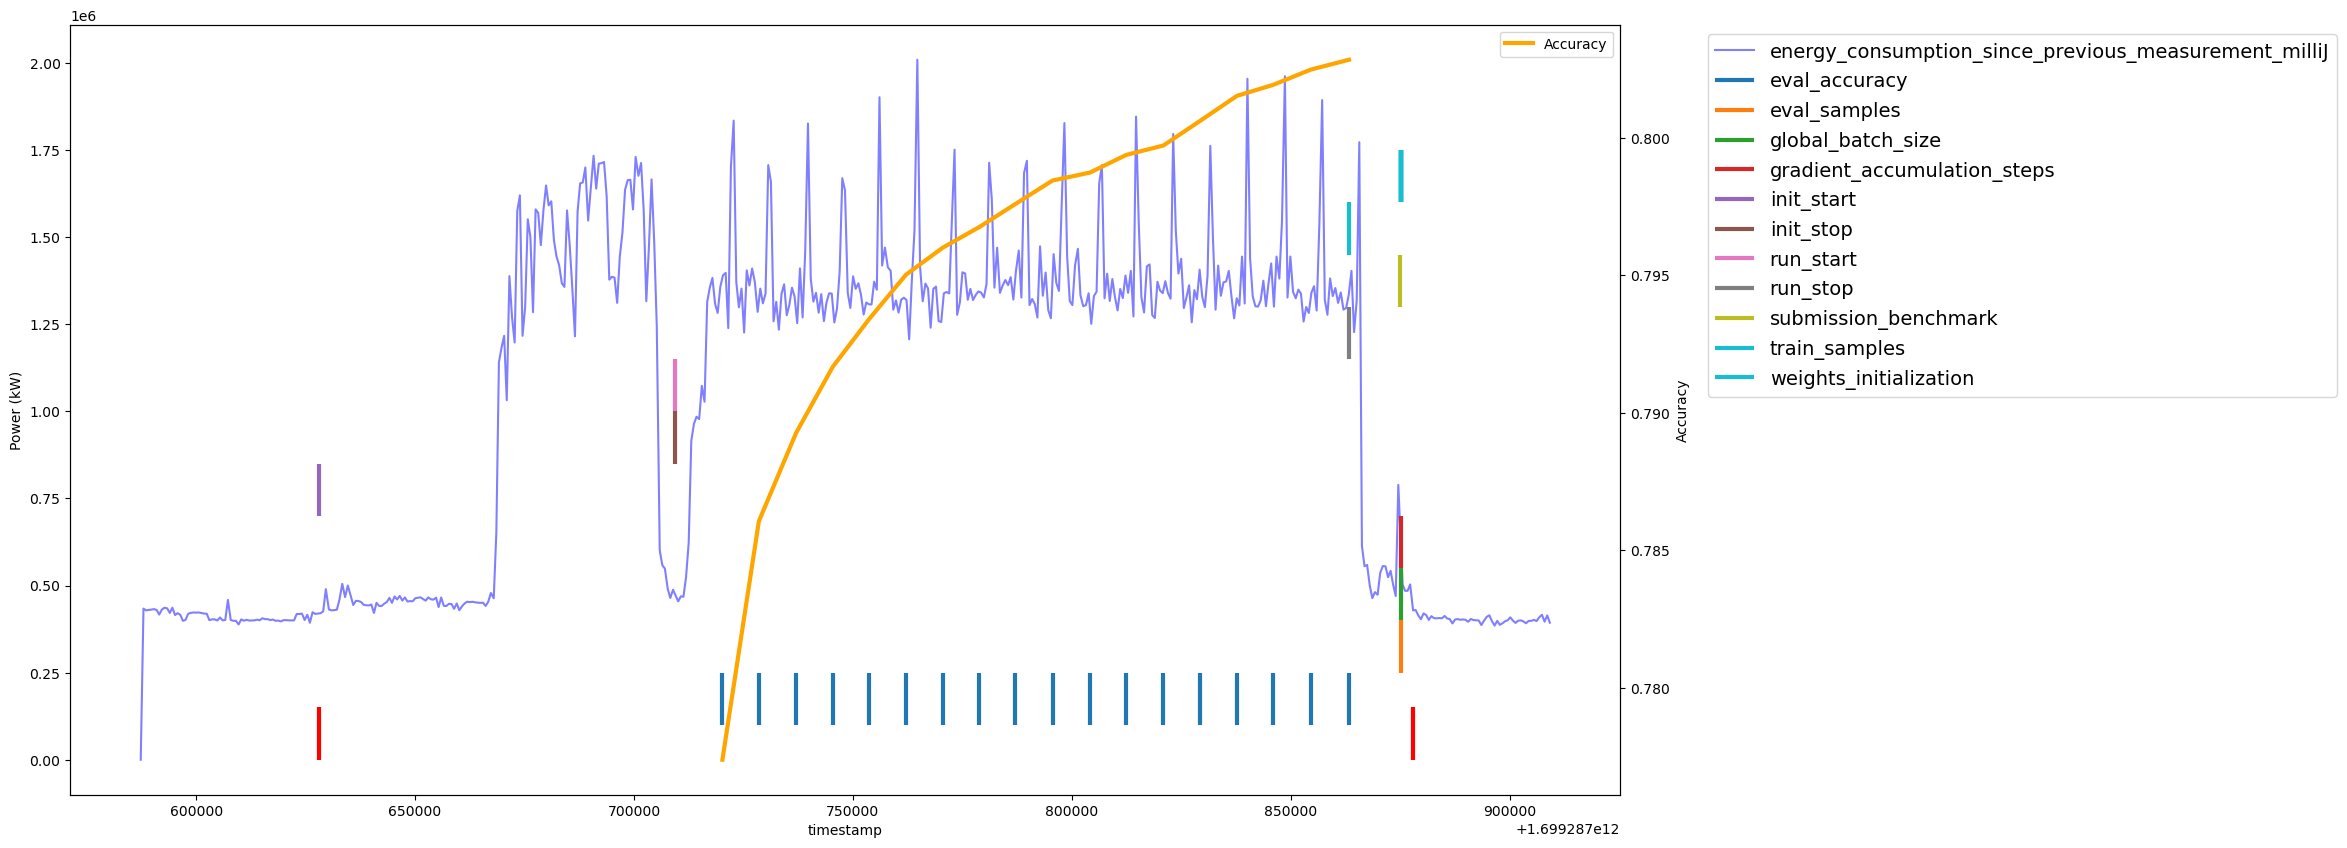

In [7]:
import itertools
import numpy as np
keys = ['eval_accuracy', 'eval_samples', 'global_batch_size',
       'gradient_accumulation_steps', 'init_start', 'init_stop',
       'run_start', 'run_stop', 
       'submission_benchmark', #'submission_division', 'submission_org', 'submission_platform','submission_status', 
       'train_samples', 'weights_initialization']

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()
energy[energy["job"]==job].sort_values(by="timestamp").groupby("timestamp")[["energy_consumption_since_previous_measurement_milliJ"]].sum().compute().plot(ax=ax,y="energy_consumption_since_previous_measurement_milliJ", color="blue", alpha=0.5)
ax.set_ylabel("Power (kW)")

COLOR = plt.cm.tab10
iter = itertools.cycle(COLOR(np.linspace(0, 1, len(keys))))
ymin = 1e5
size = 1.5e5
for key in keys:
    color = next(iter)
    ax.vlines(x=mllog[mllog["key"]==key]["timestamp"], ymin=ymin, ymax=ymin+size, color=color, linewidth=3, label=key)
    ymin+=size
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)

ax.vlines(x=jobs[jobs["job"]==job]["start_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")
ax.vlines(x=jobs[jobs["job"]==job]["end_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")

mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].plot(ax=ax2,x="timestamp", y="value", label="Accuracy", color="orange", linewidth=3)
ax2.set_ylabel("Accuracy")



# For all jobs

In [8]:
def compute_energy_between_accuracies(row):
        """Compute energy between two accuracy values."""
        mask = (energy["timestamp"]>=row["timestamp"]-row["time_diff"])&(energy["timestamp"]<=row["timestamp"])
        energy_between_accuracies = energy[mask]["energy_kWh"].sum().compute()
        return energy_between_accuracies

accuracy_df = pd.DataFrame()

for job in jobs["job"].unique():
    file = jobs[jobs["job"]==job]["file"].values[0]
    file.split("/")[-2:]    
    log_file = path + "/".join(file.split("/")[-2:])

    loglines, _ = parse_file(log_file, ruleset="2.1.0")
    mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
    mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

    acc_df = mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].reset_index(drop=True)
    acc_df["time_diff"] = acc_df["timestamp"].diff()
    acc_df["acc_diff"] = acc_df["value"].diff()
    acc_df.rename(columns={"value":"accuracy"}, inplace=True)
    acc_df.at[0, "acc_diff"] = acc_df.at[0, "accuracy"]
    first_timestamp = acc_df.at[0, "timestamp"]
    run_start = mllog[mllog["key"]=='run_start']["timestamp"].values[0]
    acc_df.at[0, "time_diff"] = first_timestamp - run_start
    acc_df["energy_kWh"] = acc_df.apply(compute_energy_between_accuracies, axis=1)
    acc_df["energy_kWh_cumsum"] = acc_df["energy_kWh"].cumsum()
    acc_df.loc[len(acc_df)] = None
    acc_df = acc_df.shift(1).fillna(0)
    acc_df["job"] = job
    
    accuracy_df = pd.concat([accuracy_df, acc_df])


In [9]:
accuracy_job = accuracy_df.merge(jobs, on="job", how="left")

In [10]:
accuracy_job.columns

Index(['timestamp', 'accuracy', 'time_diff', 'acc_diff', 'energy_kWh_x',
       'energy_kWh_cumsum', 'job', 'energy_kWh_y', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'start_time_ms', 'end_time_ms', 'epoch_nb', 'block_nb',
       'eval_nb', 'mllog_submission_benchmark', 'mllog_submission_org',
       'mllog_submission_division', 'mllog_submission_status',
       'mllog_submission_platform', 'mllog_eval_samples',
       'mllog_global_batch_size', 'mllog_opt_base_learning_rate',
       'mllog_sgd_opt_base_learning_rate',
       'mllog_sgd_opt_learning_rate_decay_poly_power',
       'mllog_opt_learning_rate_warmup_steps',
       'mllog_opt_learning_rate_warmup_factor', 'mllog_lr_decay_start_steps',
       'mllog_sgd_opt_learning_rate_decay_steps',
       'mllog_gradient_accumulation_steps', 'mllog_eval_accuracy',
       'mllog_tracked_stats', 'mllog_train_samples', 'node_nb'],
      dtype='object')

In [11]:
# accuracy_job.style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

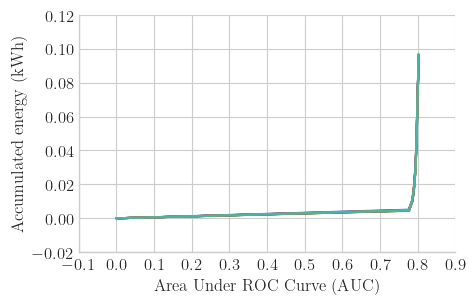

In [16]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="accuracy", y="energy_kWh_cumsum",
    data=accuracy_job, 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set_xlabels("Area Under ROC Curve (AUC)", fontsize=FONTSIZE)
ax.set_ylabels("Accumulated energy (kWh)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
ax.savefig(f"{graph_dir}/dlrm.pdf", dpi=300)